# Cluster Bacillus Sequences with unknown functions with carbohydrate metabolism Bacillus sequences 


In [1]:
#imports 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns 

In [68]:
#read in unknown sequences embedded with the unknown Protvec model 
embedding_unk_s =pd.read_csv('../Annotating_Bacterial_Function_Space_DATA/bacillus_unknown_embeddingset_unknownembedded.tsv', sep = '\t')
embedding_unk = embedding_unk_s.dropna()
embedding_unk = embedding_unk.sort_values(by=['Unnamed: 0'])
unk_keys = list(embedding_unk['Unnamed: 0'].values)

#read in carbohydrate metabolism sequences embedded with the unknown Protvec model 
embedding_known_s =pd.read_csv('../Annotating_Bacterial_Function_Space_DATA/bacillus_carbohydratemetabolism_embeddingset_unknownembedded.tsv', sep = '\t')
embedding_known = embedding_known_s.dropna()
embedding_known = embedding_known.sort_values(by=['Unnamed: 0'])
known_keys = list(embedding_known['Unnamed: 0'].values)

#merge the two embeddings 
merged_embedding = pd.concat([embedding_unk, embedding_known], axis = 0) 

In [69]:
#get the subsystems labels 
#need to read in some file which will map the sequences to the known hierachical classification (KEGG, Subsystems)
sub_sys = pd.read_csv('/home/grig0076/GitHubs/ProtvecBacterialProteins/Annotating_Bacterial_Function_Space_DATA/bacillus.ids.tsv', sep = '\t', header = None)
sub_sys.columns =  ['fig_ID', 'species', 'superclass', 'class', 'subclass', 'subsystem', 'product role_name']

#get the file which takes the md5 hashes to the fig IDs 
md5_fig = pd.read_csv('/home/grig0076/GitHubs/ProtvecBacterialProteins/Annotating_Bacterial_Function_Space_DATA/bacillus.md5.ids', sep = '\t', header = None)
md5_fig.columns = ['md5', 'fig_ID']

#assemble as a dictionary which takes a seqence key to the ontological represenation 
seqs_keys_figID = pd.concat([md5_fig[md5_fig['md5'] == key] for key in known_keys])

In [71]:
#make dictionaries for subclass/superclass but this time include the entry 'dual'
fig2subclass = sub_sys[['fig_ID', 'subclass']].drop_duplicates()

#change fig_IDs which have more than one subclass to 'dual'
duplicate_subclasses = pd.DataFrame(fig2subclass['fig_ID'].value_counts())
duplicate_subclasses = duplicate_subclasses[duplicate_subclasses['fig_ID'] > 1].index.values
duplicate_removed_subclasses = fig2subclass[~fig2subclass['fig_ID'].isin(duplicate_subclasses)]

dual_vec = ['dual' for i in range(0,len(duplicate_subclasses))]
dual_subclasses = pd.DataFrame({'fig_ID': duplicate_subclasses, 'subclass': dual_vec})
fig2subclass = pd.concat([duplicate_removed_subclasses, dual_subclasses], axis = 0)

#make these dataframes into dictionaries 
subclass_dict = dict(zip(fig2subclass['fig_ID'].values, fig2subclass['subclass'].values))

#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID['Subclass'] = [subclass_dict.get(fig_id) for fig_id in seqs_keys_figID['fig_ID']]

#collapse by subclass and subsystem 
seqs_subclass = seqs_keys_figID[['md5', 'Subclass']].drop_duplicates()

In [94]:
#replace the dual labels 
seqs_subclass = seqs_subclass.replace('dual', 'CO2 fixation and C-1 compound metabolism')

cmap = ('#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#D3D3D3' )

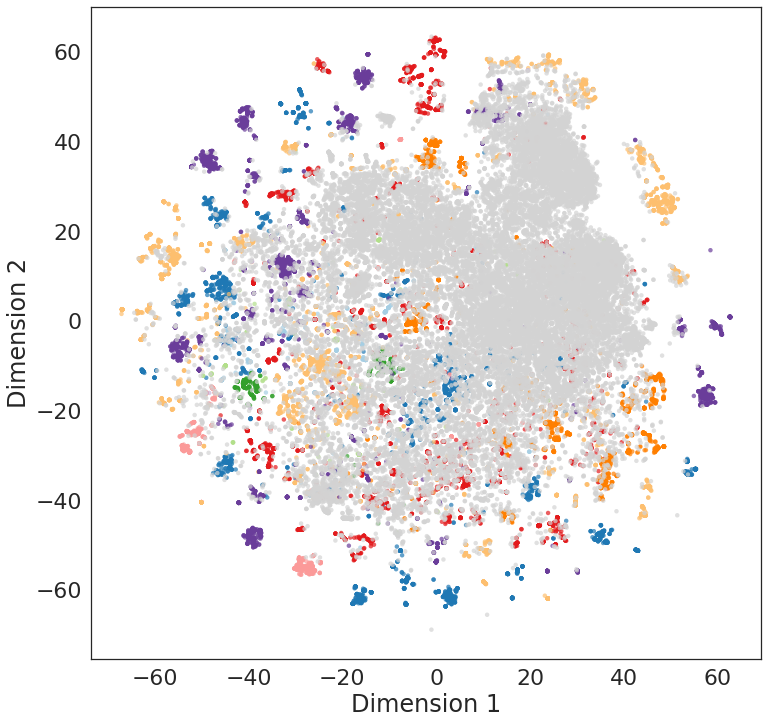

In [98]:
scaled_merged_embedding = StandardScaler().fit_transform(merged_embedding.drop(['Unnamed: 0'], axis=1).values)

tsne = TSNE(perplexity=50)
embedding_tsne = tsne.fit_transform(scaled_merged_embedding)

tsne_df = pd.DataFrame(embedding_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df.index = unk_keys+known_keys
#pca_df = pca_df.loc[close_md5_centroid_all['md5']]
tsne_df['known'] = ['k' for k in  known_keys] + ['u' for u in unk_keys] 
tsne_df['function'] = ['u' for u in unk_keys] + seqs_subclass['Subclass'].to_list() 
tsne_df = tsne_df.sort_values('function') 

#pca_df = pca_df[pca_df.index.isin(close_md5_centroid_all['md5'] )]

plt.figure(figsize=(12,12))
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'function', 
                data = tsne_df, legend = 'full', s = 20,linewidth=0, alpha = 0.7, palette = cmap )
plt.legend([],[], frameon=False)